In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import os

In [17]:
class SpanishGenderClassifier:
    def __init__(self, csv_path=None):
        self.model_name = "dccuchile/bert-base-spanish-wwm-cased"
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name)
            print(f"Modelo BERT cargado: {self.model_name}")
        except:
            self.model_name = "bert-base-multilingual-cased"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name)
            print(f"Modelo BERT fallback cargado: {self.model_name}")
        
        # Diccionarios base
        self.male_names = {
            'juan', 'carlos', 'miguel', 'jose', 'luis', 'antonio', 'francisco', 
            'manuel', 'pedro', 'angel', 'alejandro', 'diego', 'daniel', 'andres', 
            'fernando', 'sergio', 'pablo', 'rafael', 'ricardo', 'jorge', 'alberto', 
            'eduardo', 'roberto', 'oscar', 'arturo', 'david', 'javier', 'sebastian', 
            'santiago', 'felipe', 'nicolas', 'cristian', 'camilo', 'leonardo', 
            'julian', 'mauricio', 'ivan', 'raul', 'mario', 'cesar', 'gabriel'
        }
        
        self.female_names = {
            'maria', 'ana', 'carmen', 'josefina', 'rosa', 'francisca', 'laura', 
            'antonia', 'dolores', 'pilar', 'teresa', 'elena', 'isabel', 'cristina', 
            'monica', 'sandra', 'patricia', 'lucia', 'beatriz', 'sara', 'adriana', 
            'paola', 'claudia', 'andrea', 'natalia', 'carolina', 'valentina', 
            'camila', 'sofia', 'daniela', 'karen', 'melissa', 'gabriela', 
            'alejandra', 'mariana', 'paula', 'diana', 'lina', 'katherine', 'jenny'
        }
        
        if csv_path:
            self.load_external_dataset(csv_path)
    
    def load_external_dataset(self, csv_path):
        """Carga el dataset externo de nombres y géneros"""
        try:
            df_names = pd.read_csv(csv_path, header=None, names=['name', 'gender', 'sources'])
            print(f"Cargando {len(df_names)} nombres del dataset externo...")
            
            male_count = 0
            female_count = 0
            
            for _, row in df_names.iterrows():
                name = str(row['name']).strip().lower()
                gender = str(row['gender']).strip().upper()
                first_name = name.split()[0] if ' ' in name else name
                
                if gender == 'M':
                    self.male_names.add(first_name)
                    male_count += 1
                elif gender == 'F':
                    self.female_names.add(first_name)
                    female_count += 1
            
            print(f"Diccionarios actualizados:")
            print(f"- Nombres masculinos agregados: {male_count}")
            print(f"- Nombres femeninos agregados: {female_count}")
            print(f"- Total masculinos: {len(self.male_names)}")
            print(f"- Total femeninos: {len(self.female_names)}")
            
        except Exception as e:
            print(f"Error cargando dataset externo: {e}")
    
    def extract_features(self, name):
        """Extrae características del nombre para clasificación"""
        if pd.isna(name) or name == 'NA':
            return None
        
        # Verificar si es un usuario anónimo
        if self.is_anonymous_user(name):
            return None
            
        name_clean = str(name).strip().split()[0].lower()
        
        features = {
            'ends_with_a': name_clean.endswith('a'),
            'ends_with_o': name_clean.endswith('o'),
            'ends_with_ia': name_clean.endswith('ia'),
            'ends_with_ez': name_clean.endswith('ez'),
            'contains_mar': 'mar' in name_clean,
            'length': len(name_clean),
            'in_male_dict': name_clean in self.male_names,
            'in_female_dict': name_clean in self.female_names
        }
        
        return features, name_clean
    
    def is_anonymous_user(self, name):
        """Detecta si el usuario es anónimo"""
        if pd.isna(name) or name == 'NA':
            return True
        
        name_str = str(name).strip().lower()
        
        # Verificar patrones de usuarios anónimos
        import re
        
        # Patrón para "Anonymous participant" seguido de números
        anonymous_pattern = r'^anonymous\s+participant\s*\d*$'
        
        if re.match(anonymous_pattern, name_str):
            return True
        
        # Otros patrones anónimos comunes
        anonymous_patterns = [
            r'^anonymous$',
            r'^anon\d*$',
            r'^user\d+$',
            r'^guest\d*$'
        ]
        
        for pattern in anonymous_patterns:
            if re.match(pattern, name_str):
                return True
        
        return False

    def get_bert_embedding(self, name):
        """Obtiene embeddings de BERT para el nombre"""
        try:
            # Crear un contexto simple para el nombre
            context = f"El nombre {name} pertenece a una persona"
            
            # Tokenizar
            inputs = self.tokenizer(context, return_tensors="pt", truncation=True, max_length=128)
            
            # Obtener embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Usar el embedding del token [CLS]
                embeddings = outputs.last_hidden_state[:, 0, :].squeeze()
            
            return embeddings.numpy()
        except Exception as e:
            print(f"Error obteniendo embedding para {name}: {e}")
            return None
    
    def classify_with_bert_similarity(self, name):
        """Clasificación usando similitud con nombres conocidos via BERT"""
        name_embedding = self.get_bert_embedding(name)
        if name_embedding is None:
            return 'unknown', 0.0
        
        # Muestras de nombres masculinos y femeninos para comparar
        male_samples = ['juan', 'carlos', 'miguel', 'jose', 'antonio']
        female_samples = ['maria', 'ana', 'carmen', 'laura', 'patricia']
        
        male_similarities = []
        female_similarities = []
        
        # Calcular similaridades con nombres masculinos
        for male_name in male_samples:
            male_embedding = self.get_bert_embedding(male_name)
            if male_embedding is not None:
                # Similitud coseno
                similarity = np.dot(name_embedding, male_embedding) / (
                    np.linalg.norm(name_embedding) * np.linalg.norm(male_embedding)
                )
                male_similarities.append(similarity)
        
        # Calcular similaridades con nombres femeninos
        for female_name in female_samples:
            female_embedding = self.get_bert_embedding(female_name)
            if female_embedding is not None:
                similarity = np.dot(name_embedding, female_embedding) / (
                    np.linalg.norm(name_embedding) * np.linalg.norm(female_embedding)
                )
                female_similarities.append(similarity)
        
        # Promediar similaridades
        avg_male_sim = np.mean(male_similarities) if male_similarities else 0
        avg_female_sim = np.mean(female_similarities) if female_similarities else 0
        
        # Clasificar basado en mayor similitud
        if avg_male_sim > avg_female_sim and avg_male_sim > 0.7:
            return 'male', avg_male_sim
        elif avg_female_sim > avg_male_sim and avg_female_sim > 0.7:
            return 'female', avg_female_sim
        else:
            return 'unknown', max(avg_male_sim, avg_female_sim)
    
    def classify_gender_hybrid(self, name):
        """Clasificación híbrida: Diccionarios + Morfología + BERT"""
        
        # Verificar si es anónimo
        if self.is_anonymous_user(name):
            return 'anonymous'
        
        result = self.extract_features(name)
        if result is None:
            return 'unknown'
            
        features, name_clean = result
        
        # NIVEL 1: Diccionario (máxima confianza)
        if features['in_male_dict']:
            return 'male'
        elif features['in_female_dict']:
            return 'female'
        
        # NIVEL 2: Reglas morfológicas
        morph_score = 0
        
        # Terminaciones femeninas
        if features['ends_with_a'] and not name_clean.endswith('ista'):
            morph_score += 2
        if features['ends_with_ia']:
            morph_score += 3
        if name_clean.endswith(('ina', 'ana', 'ela', 'ica')):
            morph_score += 2
        
        # Terminaciones masculinas
        if features['ends_with_o']:
            morph_score -= 2
        if name_clean.endswith(('an', 'el', 'or', 'us')):
            morph_score -= 2
        
        # Si morfología es concluyente
        if morph_score > 2:
            return 'female'
        elif morph_score < -2:
            return 'male'
        
        # NIVEL 3: BERT para casos ambiguos
        bert_gender, bert_confidence = self.classify_with_bert_similarity(name_clean)
        
        if bert_confidence > 0.75:  # Alta confianza de BERT
            return bert_gender
        elif morph_score > 0:  # Morfología sugiere femenino
            return 'female'
        elif morph_score < 0:  # Morfología sugiere masculino
            return 'male'
        else:
            return bert_gender if bert_gender != 'unknown' else 'unknown'
    
    def get_classification_stats_hybrid(self, names_series):
        """Aplica clasificación híbrida y retorna estadísticas"""
        print(f"Clasificando {len(names_series)} nombres con método híbrido (Diccionarios + Morfología + BERT)...")
        
        # Aplicar clasificación híbrida
        results = names_series.apply(self.classify_gender_hybrid)
        
        # Mostrar estadísticas
        stats = results.value_counts()
        percentages = results.value_counts(normalize=True) * 100
        
        print("Estadísticas de clasificación híbrida:")
        print("-" * 40)
        for gender in ['male', 'female', 'anonymous', 'unknown']:
            count = stats.get(gender, 0)
            pct = percentages.get(gender, 0)
            print(f"{gender.capitalize()}: {count} ({pct:.1f}%)")
        
        return results

In [22]:
# Cargar el dataset principal desde la carpeta data

# Definir la ruta al dataset principal
data_path = "../../data/dataset_completo_Cleaned.csv"
df = pd.read_csv(data_path)

print(f"Dataset cargado: {len(df)} filas")
print(f"Columnas: {df.columns.tolist()}")
print(f"NAN en postAuthor: {df['postAuthor'].isna().sum()}")
print(f"NAN en commentAuthorName: {df['commentAuthorName'].isna().sum()}")

# Usar el clasificador híbrido con el dataset de nombres
csv_path = "03 Names R3.csv"
classifier = SpanishGenderClassifier(csv_path=csv_path)

print("\n" + "="*60)
print("ANÁLISIS 1: ENFOQUE EN POST AUTHORS")
print("="*60)

# Crear una copia del dataset original para análisis de postAuthor
df_posts = df.copy()

# Eliminar filas donde postAuthor es NAN
df_posts_clean = df_posts.dropna(subset=['postAuthor'])

print(f"Dataset original: {len(df)} filas")
print(f"Dataset limpio (sin NAN en postAuthor): {len(df_posts_clean)} filas")
print(f"Filas eliminadas: {len(df) - len(df_posts_clean)}")

# Aplicar clasificación híbrida a postAuthor
print("\nClasificando géneros en autores de posts (método híbrido):")
df_posts_clean['postAuthor_gender_hybrid'] = classifier.get_classification_stats_hybrid(df_posts_clean['postAuthor'])

print("\n" + "="*60)
print("ANÁLISIS 2: ENFOQUE EN COMMENT AUTHORS")
print("="*60)

# Crear otra copia del dataset original para análisis de commentAuthorName
df_comments = df.copy()

# Eliminar filas donde commentAuthorName es NAN
df_comments_clean = df_comments.dropna(subset=['commentAuthorName'])

print(f"Dataset original: {len(df)} filas")
print(f"Dataset limpio (sin NAN en commentAuthorName): {len(df_comments_clean)} filas")
print(f"Filas eliminadas: {len(df) - len(df_comments_clean)}")

# Aplicar clasificación híbrida a commentAuthorName
print("\nClasificando géneros en autores de comentarios (método híbrido):")
df_comments_clean['commentAuthor_gender_hybrid'] = classifier.get_classification_stats_hybrid(df_comments_clean['commentAuthorName'])

# Guardar ambos datasets clasificados
print("\n" + "="*60)
print("GUARDANDO RESULTADOS")
print("="*60)

# Guardar dataset de posts
output_path_posts = "../../data/dataset_posts_with_gender_hybrid.csv"
df_posts_clean.to_csv(output_path_posts, index=False)
print(f"Dataset de posts con clasificación híbrida guardado en: {output_path_posts}")

# Guardar dataset de comentarios
output_path_comments = "../../data/dataset_comments_with_gender_hybrid.csv"
df_comments_clean.to_csv(output_path_comments, index=False)
print(f"Dataset de comentarios con clasificación híbrida guardado en: {output_path_comments}")

# Mostrar ejemplos de clasificación
print("\n" + "="*60)
print("EJEMPLOS DE CLASIFICACIÓN HÍBRIDA")
print("="*60)

print("\nEjemplos - POST AUTHORS:")
examples_posts = df_posts_clean[['postAuthor', 'postAuthor_gender_hybrid']].drop_duplicates().head(10)
for _, row in examples_posts.iterrows():
    print(f"{row['postAuthor']}: {row['postAuthor_gender_hybrid']}")

print("\nEjemplos - COMMENT AUTHORS:")
examples_comments = df_comments_clean[['commentAuthorName', 'commentAuthor_gender_hybrid']].drop_duplicates().head(10)
for _, row in examples_comments.iterrows():
    print(f"{row['commentAuthorName']}: {row['commentAuthor_gender_hybrid']}")

Dataset cargado: 1836 filas
Columnas: ['postId', 'postAuthor', 'postText', 'creationTime', 'postUrl', 'commentAuthorName', 'commentText', 'commentId', 'depth']
NAN en postAuthor: 672
NAN en commentAuthorName: 1164


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo BERT cargado: dccuchile/bert-base-spanish-wwm-cased
Cargando 83121 nombres del dataset externo...
Diccionarios actualizados:
- Nombres masculinos agregados: 36611
- Nombres femeninos agregados: 35910
- Total masculinos: 14340
- Total femeninos: 13859

ANÁLISIS 1: ENFOQUE EN POST AUTHORS
Dataset original: 1836 filas
Dataset limpio (sin NAN en postAuthor): 1164 filas
Filas eliminadas: 672

Clasificando géneros en autores de posts (método híbrido):
Clasificando 1164 nombres con método híbrido (Diccionarios + Morfología + BERT)...
Estadísticas de clasificación híbrida:
----------------------------------------
Male: 462 (39.7%)
Female: 444 (38.1%)
Anonymous: 258 (22.2%)
Unknown: 0 (0.0%)

ANÁLISIS 2: ENFOQUE EN COMMENT AUTHORS
Dataset original: 1836 filas
Dataset limpio (sin NAN en commentAuthorName): 672 filas
Filas eliminadas: 1164

Clasificando géneros en autores de comentarios (método híbrido):
Clasificando 672 nombres con método híbrido (Diccionarios + Morfología + BERT)...


C:\Users\Christian\AppData\Local\Temp\ipykernel_12388\3226914781.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts_clean['postAuthor_gender_hybrid'] = classifier.get_classification_stats_hybrid(df_posts_clean['postAuthor'])


Estadísticas de clasificación híbrida:
----------------------------------------
Male: 377 (56.1%)
Female: 170 (25.3%)
Anonymous: 124 (18.5%)
Unknown: 1 (0.1%)

GUARDANDO RESULTADOS
Dataset de posts con clasificación híbrida guardado en: ../../data/dataset_posts_with_gender_hybrid.csv
Dataset de comentarios con clasificación híbrida guardado en: ../../data/dataset_comments_with_gender_hybrid.csv

EJEMPLOS DE CLASIFICACIÓN HÍBRIDA

Ejemplos - POST AUTHORS:
Maortz Ortz: male
Paula Andrea: female
Jhonatan Granados: male
Esperanza Mejia: female
Anonymous participant: anonymous
Yamith Caicedo: female
Miyeth KaSe: male
Felipe Investigador Tesista: male
Sofia Palacios: female
Karen Mancilla: female

Ejemplos - COMMENT AUTHORS:
Anonymous participant 862: anonymous
Anonymous participant 772: anonymous
Daniel Santiago: male
Anonymous participant 836: anonymous
Felipe Vera: male
Alexander Rodriguez: male
Claudia Morales: female
Lau Doncel: male
Tatiana Calderon Hernandez: female
Nathi Jimenez: fem

C:\Users\Christian\AppData\Local\Temp\ipykernel_12388\3226914781.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments_clean['commentAuthor_gender_hybrid'] = classifier.get_classification_stats_hybrid(df_comments_clean['commentAuthorName'])


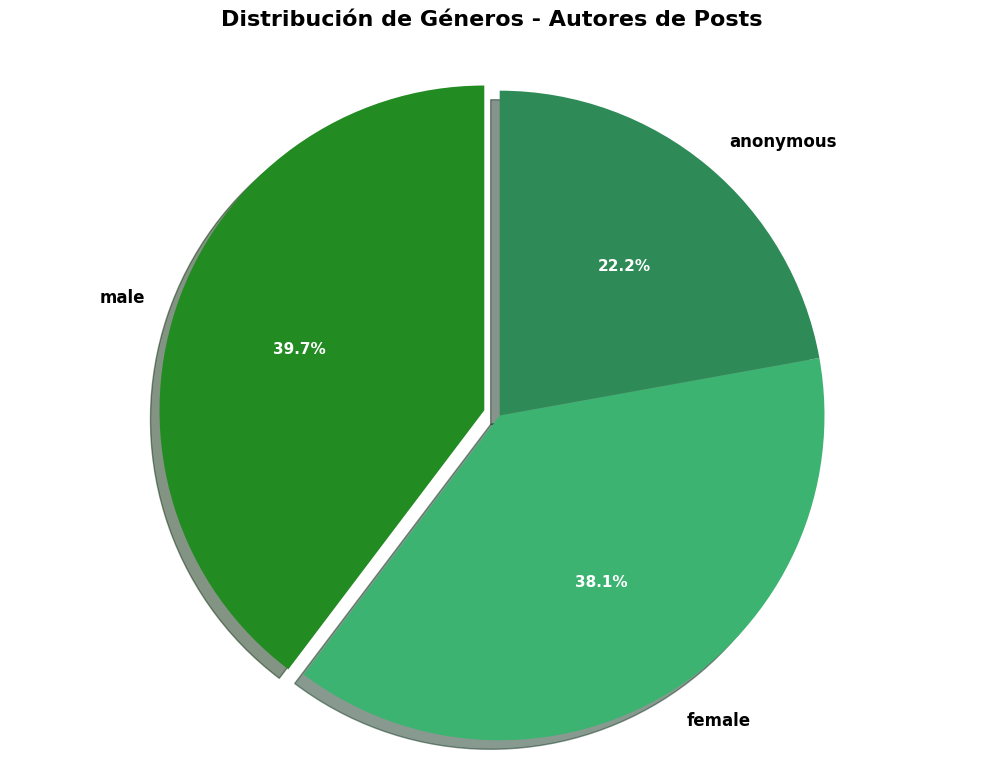

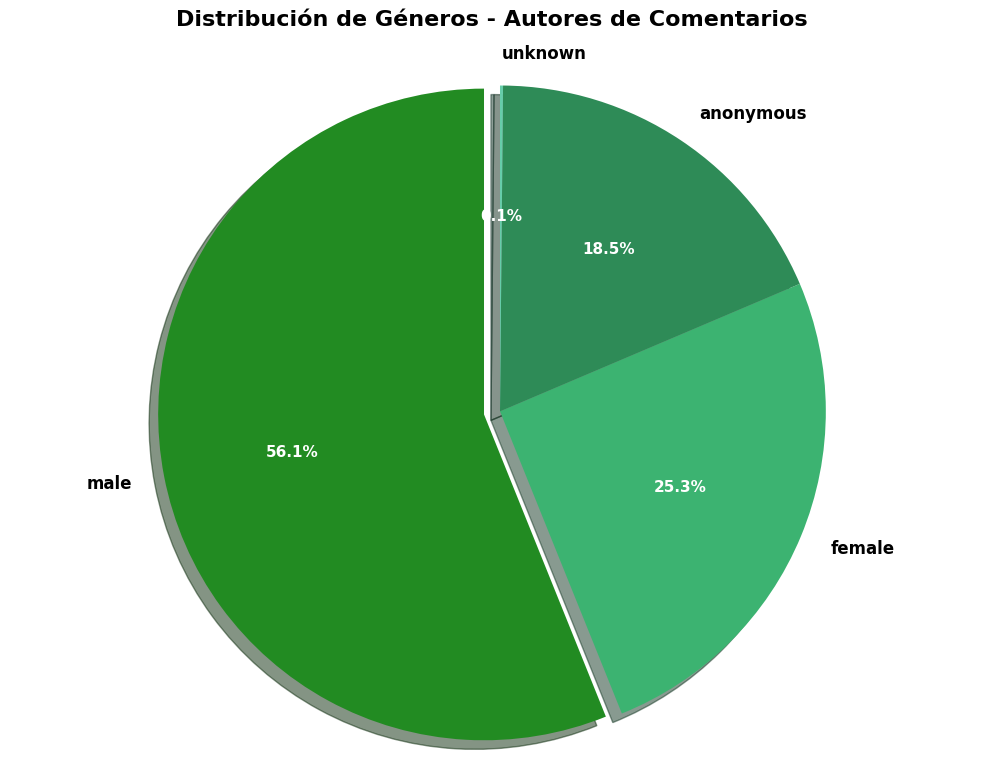

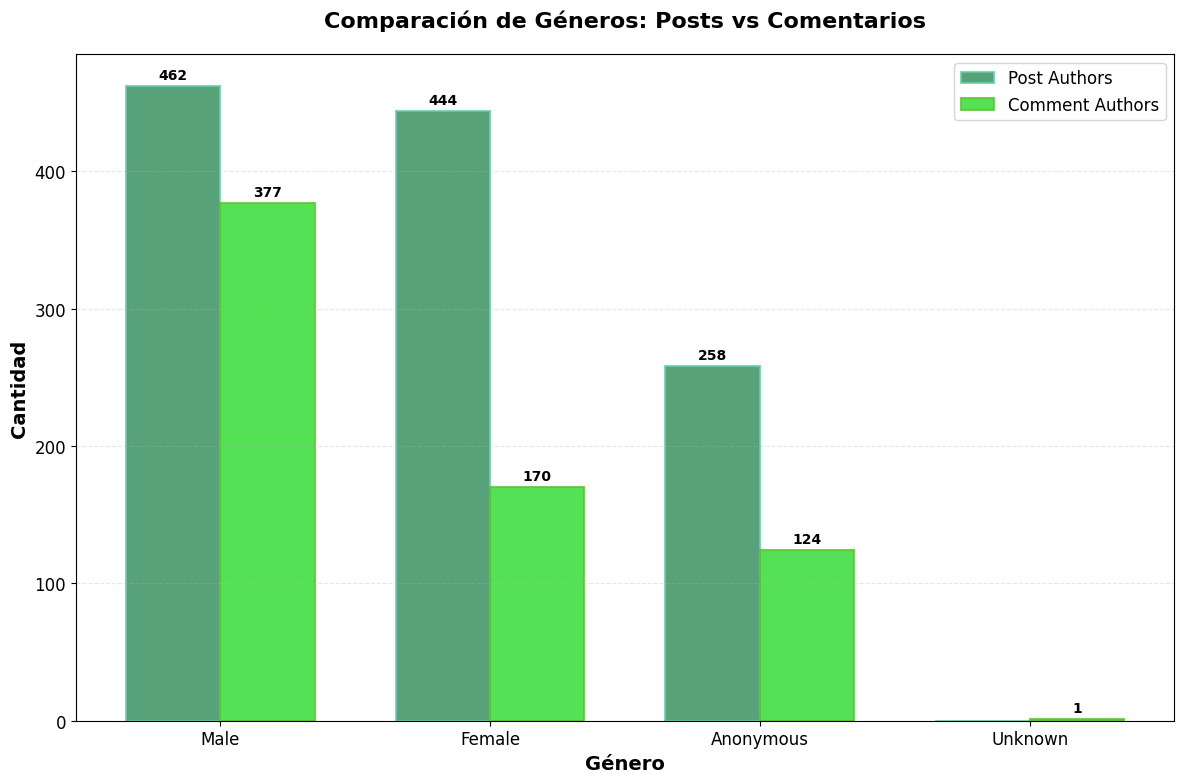

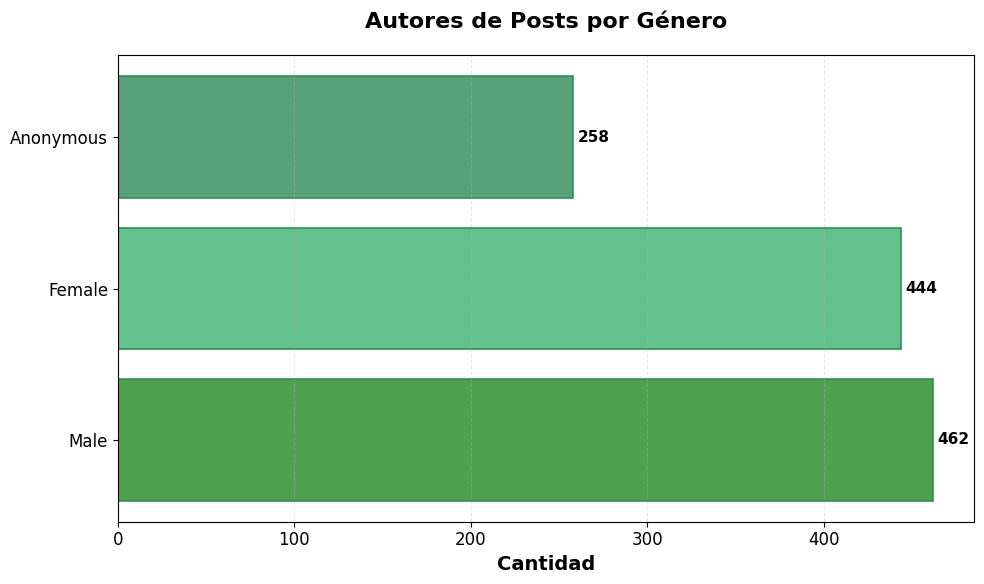

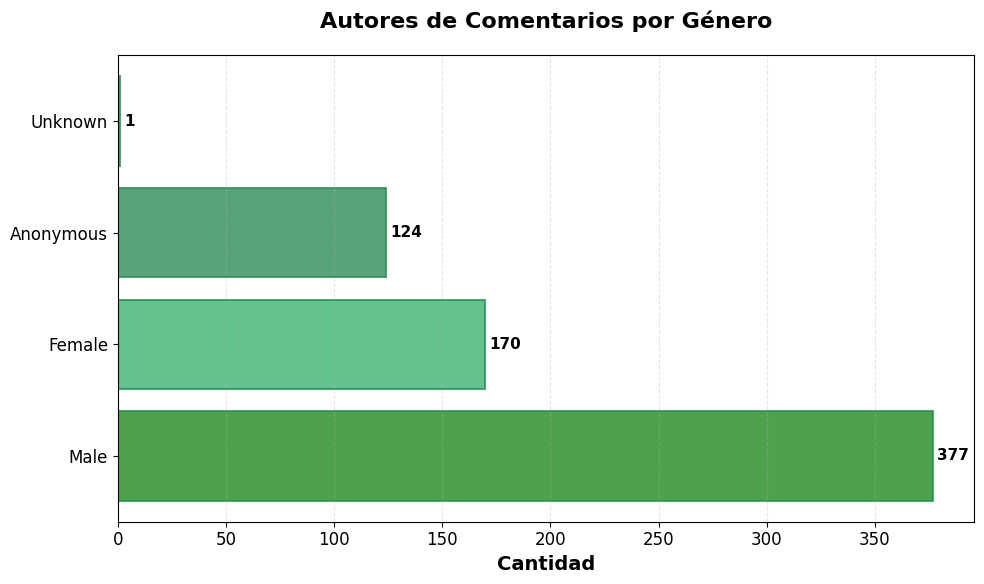

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de los gráficos con paleta verde
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Definir paleta de colores verde
green_colors = ['#228B22', '#3CB371', '#2E8B57', '#66CDAA']  # ForestGreen, MediumSeaGreen, SeaGreen, MediumAquamarine
extended_green_colors = ['#228B22', '#3CB371', '#2E8B57', '#66CDAA', '#90EE90', '#A9DFBF']  # + LightGreen, Verde pastel

print("="*60)

# 1. GRÁFICO DE TORTA - AUTORES DE POSTS
post_stats = df_posts_clean['postAuthor_gender_hybrid'].value_counts()

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(post_stats.values, 
                                  labels=post_stats.index, 
                                  autopct='%1.1f%%',
                                  colors=green_colors[:len(post_stats)],
                                  startangle=90,
                                  explode=[0.05 if i == 0 else 0 for i in range(len(post_stats))],
                                  shadow=True)

# Mejorar la apariencia del texto
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.title('Distribución de Géneros - Autores de Posts', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 2. GRÁFICO DE TORTA - AUTORES DE COMENTARIOS
comment_stats = df_comments_clean['commentAuthor_gender_hybrid'].value_counts()

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(comment_stats.values, 
                                  labels=comment_stats.index, 
                                  autopct='%1.1f%%',
                                  colors=green_colors[:len(comment_stats)],
                                  startangle=90,
                                  explode=[0.05 if i == 0 else 0 for i in range(len(comment_stats))],
                                  shadow=True)

# Mejorar la apariencia del texto
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.title('Distribución de Géneros - Autores de Comentarios', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 3. GRÁFICO DE BARRAS COMPARATIVO
categories = ['Male', 'Female', 'Anonymous', 'Unknown']
post_counts = [post_stats.get(cat.lower(), 0) for cat in categories]
comment_counts = [comment_stats.get(cat.lower(), 0) for cat in categories]

x = range(len(categories))
width = 0.35

plt.figure(figsize=(12, 8))
bars1 = plt.bar([i - width/2 for i in x], post_counts, width, 
               label='Post Authors', color= '#2E8B57', alpha=0.8, edgecolor= '#66CDAA', linewidth=1.5)
bars2 = plt.bar([i + width/2 for i in x], comment_counts, width, 
               label='Comment Authors', color="#2ADA2ABC", alpha=0.8, edgecolor="#5CC22EC0", linewidth=1.5)

plt.xlabel('Género', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad', fontsize=14, fontweight='bold')
plt.title('Comparación de Géneros: Posts vs Comentarios', fontweight='bold', fontsize=16, pad=20)
plt.xticks(x, categories, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. GRÁFICO DE BARRAS HORIZONTALES - POSTS
plt.figure(figsize=(10, 6))
y_pos = range(len(post_stats))
bars = plt.barh(y_pos, post_stats.values, color=green_colors[:len(post_stats)], 
               alpha=0.8, edgecolor='#2E8B57', linewidth=1.5)

plt.yticks(y_pos, [label.capitalize() for label in post_stats.index], fontsize=12)
plt.xlabel('Cantidad', fontsize=14, fontweight='bold')
plt.title('Autores de Posts por Género', fontweight='bold', fontsize=16, pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.annotate(f'{int(width):,}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. GRÁFICO DE BARRAS HORIZONTALES - COMENTARIOS
plt.figure(figsize=(10, 6))
y_pos = range(len(comment_stats))
bars = plt.barh(y_pos, comment_stats.values, color=green_colors[:len(comment_stats)], 
               alpha=0.8, edgecolor='#2E8B57', linewidth=1.5)

plt.yticks(y_pos, [label.capitalize() for label in comment_stats.index], fontsize=12)
plt.xlabel('Cantidad', fontsize=14, fontweight='bold')
plt.title('Autores de Comentarios por Género', fontweight='bold', fontsize=16, pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.annotate(f'{int(width):,}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
